In [25]:
from PotentialField import PotentialField

grid = {
    "x_start": -2, "x_end": 2, "no_points_x": 50,
    "y_start": -1, "y_end": 1, "no_points_y": 50
}
pf = PotentialField(grid)
pf.add_free_stream(u_inf=1.0)
pf.add_source_sink(strength=5.0, x=-0.5, y=0.0)
pf.add_vortex(strength=1.0, x=0.5, y=0.0)


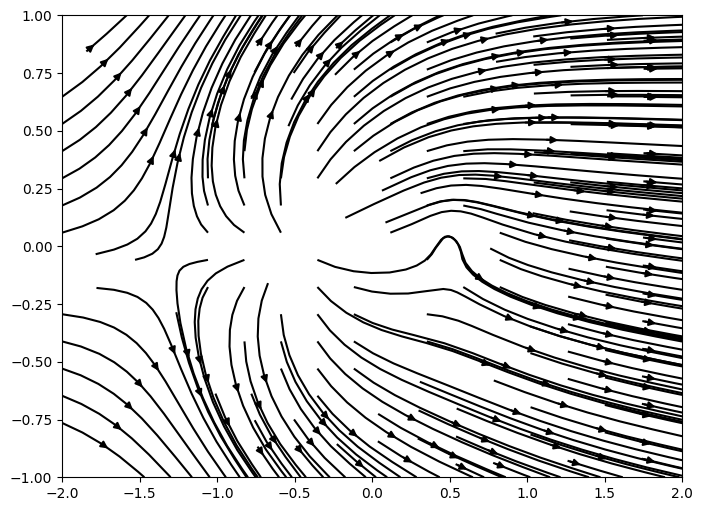

In [26]:
import matplotlib.pyplot as plt
import svgwrite
from matplotlib.collections import LineCollection

# Generate streamplot
fig, ax = plt.subplots(figsize=(8, 6))
stream = ax.streamplot(
    pf.X, pf.Y, pf.u, pf.v,
    color='k',
    density=0.6,
    integration_direction='forward',
    broken_streamlines=False
)

# Get the line segments
segments = stream.lines.get_segments()

# Create SVG drawing
dwg = svgwrite.Drawing("streamlines.svg", profile='tiny')

# Optional: scale or offset
scale = 100  # Or 1.0 for raw data
offset_x = 0
offset_y = 0


scale = 100  # Try 100–1000 depending on your vector field
height = pf.Y.max() * scale  # Used to flip Y axis

for seg in segments:
    path_data = f"M {seg[0][0]*scale},{height - seg[0][1]*scale} "
    path_data += " ".join(f"L{scale*x},{height - scale*y}" for x, y in seg[1:])
    dwg.add(dwg.path(d=path_data, stroke='black', fill='none', stroke_width=0.5))


# Save the SVG
dwg.save()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from multiprocessing import Pool
from functools import partial


def point_distance(p1, p2):
    """Calculate Euclidean distance between two points."""
    return np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)


def check_sink_proximity(p, sinks, maxdist=0.1):
    """Check if a point is within maxdist of any sink."""
    return any(point_distance(sink, p) < maxdist for sink in sinks)


def compute_trace(
    p, maxiter, max_sink_dist, grid, u_i, v_i, dt, sinks, limit=1500, max_iter_sink_proximity=0
):
    """
    Trace a streamline using 4th-order Runge–Kutta integration.
    """
    ps = []
    n = 0
    sink_soak = 0

    def velocity_at(pos):
        """Return velocity vector [u, v] at given position."""
        pt = np.array([[pos[0], pos[1]]])  # shape (1, 2)
        return np.array([u_i(pt)[0], v_i(pt)[0]])

    while (
        point_in_canvas(p, grid)
        and n <= maxiter
        and sink_soak <= max_iter_sink_proximity
    ):
        ps.append(p.copy())

        # RK4 integration
        k1 = velocity_at(p)
        k2 = velocity_at(p + 0.5 * dt * k1)
        k3 = velocity_at(p + 0.5 * dt * k2)
        k4 = velocity_at(p + dt * k3)

        p = p + (dt / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

        n += 1
        if check_sink_proximity(p, sinks, maxdist=max_sink_dist):
            sink_soak += 1

    # Reduce points to keep total length under limit
    if len(ps) > limit:
        skip = int(np.ceil(len(ps) / limit))
        ps = ps[::skip]

    return ps


def point_in_canvas(point, grid):
    """Check if a point lies within grid boundaries."""
    return (
        grid["x_start"] <= point[0] <= grid["x_end"]
        and grid["y_start"] <= point[1] <= grid["y_end"]
    )


class StreamLines:
    def __init__(self, grid):
        self.grid = grid
        self.x, self.y, self.dx, self.dy = [], [], None, None
        self.X, self.Y = [], []
        self.psi = np.zeros((grid["no_points_x"], grid["no_points_y"]))
        self.u = np.zeros_like(self.psi)
        self.v = np.zeros_like(self.psi)
        self.psis = []
        self.streamtraces = []
        self.source_sink = []
        self.vortices = []
        self.seeds = []
        self.streamtraces_color = []
        self.colors = ["red", "blue", "green", "orange", "purple", "brown"]
        self.sl_config = {}
        self.generate_mesh()

    def generate_mesh(self):
        """Generate mesh grid for computation."""
        self.x = np.linspace(self.grid["x_start"], self.grid["x_end"], self.grid["no_points_x"])
        self.y = np.linspace(self.grid["y_start"], self.grid["y_end"], self.grid["no_points_y"])
        self.dx = (self.grid["x_end"] - self.grid["x_start"]) / self.grid["no_points_x"]
        self.dy = (self.grid["y_end"] - self.grid["y_start"]) / self.grid["no_points_y"]
        self.X, self.Y = np.meshgrid(self.x, self.y)

    def add_source_sink(self, strength, x, y):
        """Add a source or sink."""
        self.source_sink.append([x, y, strength])
        psi = strength / (2 * np.pi) * np.arctan2((self.Y - y), (self.X - x))
        self.psis.append(psi)
        self.psi += psi
        self.u += strength / (2 * np.pi) * (self.X - x) / ((self.X - x)**2 + (self.Y - y)**2)
        self.v += strength / (2 * np.pi) * (self.Y - y) / ((self.X - x)**2 + (self.Y - y)**2)

    def add_free_stream(self, u_inf=0, v_inf=0):
        """Add uniform flow."""
        psi = u_inf * self.Y - v_inf * self.X
        self.psis.append(psi)
        self.psi += psi
        self.u += u_inf
        self.v += v_inf

    def add_vortex(self, strength, x, y):
        """Add a vortex."""
        self.vortices.append([x, y, strength])
        psi = strength / (4 * np.pi) * np.log((self.X - x)**2 + (self.Y - y)**2)
        self.psis.append(psi)
        self.psi += psi
        self.u += strength / (2 * np.pi) * (self.Y - y) / ((self.X - x)**2 + (self.Y - y)**2)
        self.v -= strength / (2 * np.pi) * (self.X - x) / ((self.X - x)**2 + (self.Y - y)**2)

    def reset_psi(self):
        """Recalculate psi from stored components."""
        if self.psis:
            self.psi = np.sum(self.psis, axis=0)

    def _circle_points(self, p, r, n_points):
        """Generate points on a circle."""
        return [[p[0] + np.cos(alpha) * r, p[1] + np.sin(alpha) * r]
                for alpha in np.linspace(0, 2 * np.pi, n_points + 1)]

    def calc_streamtraces(
        self, n_streamtraces=10, dt=0.005, maxiter=500, radius=0.1,
        max_sink_dist=0.1, max_iter_sink_proximity=0, seeds=["random"], n_cpu=1
    ):
        """Calculate streamline paths."""
        self.sl_config = locals()
        self.sl_config.pop("self")

        u_i = interpolate.RegularGridInterpolator((self.x, self.y), self.u, method="linear")
        v_i = interpolate.RegularGridInterpolator((self.x, self.y), self.v, method="linear")

        if not isinstance(seeds, list):
            raise Exception("seeds argument must be list")

        for item in seeds:
            if item == "random":
                xs = np.random.uniform(self.grid["x_start"], self.grid["x_end"], size=n_streamtraces)
                ys = np.random.uniform(self.grid["y_start"], self.grid["y_end"], size=n_streamtraces)
                self.seeds.extend(np.column_stack((xs, ys)).tolist())
                self.streamtraces_color.extend(np.random.choice(self.colors, n_streamtraces))

            elif item == "sources":
                seeds_center = [[x[0], x[1]] for x in self.source_sink if x[2] > 0]
                n_per_source = max(1, int(n_streamtraces / len(seeds_center)))
                for p in seeds_center:
                    pts = self._circle_points(p, radius, n_per_source)
                    self.seeds.extend(pts)
                    self.streamtraces_color.extend(np.random.choice(self.colors, len(pts)))

            elif item == "grid":
                grid_points = np.column_stack((self.X.flatten(), self.Y.flatten()))
                gridskip = max(1, int(len(grid_points) / n_streamtraces))
                self.seeds.extend(grid_points[::gridskip].tolist())
                self.streamtraces_color.extend(np.random.choice(self.colors, len(self.seeds)))

        sinks = [[x[0], x[1]] for x in self.source_sink if x[2] < 0]
        if n_cpu > 1:
            with Pool(n_cpu) as pool:
                self.streamtraces = pool.map(
                    partial(
                        compute_trace, maxiter=maxiter, max_sink_dist=max_sink_dist,
                        max_iter_sink_proximity=max_iter_sink_proximity, sinks=sinks,
                        grid=self.grid, u_i=u_i, v_i=v_i, dt=dt
                    ),
                    self.seeds
                )
        else:
            self.streamtraces = [
                compute_trace(
                    seed, maxiter=maxiter, max_sink_dist=max_sink_dist,
                    max_iter_sink_proximity=max_iter_sink_proximity, sinks=sinks,
                    grid=self.grid, u_i=u_i, v_i=v_i, dt=dt
                )
                for seed in self.seeds
            ]

    def write_svg(self, file, height=297, width=420, offset_x=210, offset_y=148.5):
        """Export streamlines to SVG."""
        dx = self.grid["x_end"] - self.grid["x_start"]
        fx = width / dx
        dy = self.grid["y_end"] - self.grid["y_start"]
        fy = height / dy

        with open(file, "w") as f:
            f.write(f'<svg height="{height}" width="{width}">')
            for streamline in self.streamtraces:
                if len(streamline) > 2:
                    path = f'M {streamline[0][0]*fx + offset_x} {streamline[0][1]*fy + offset_y} '
                    path += " ".join(f"L {p[0]*fx + offset_x} {p[1]*fy + offset_y}" for p in streamline[1:])
                    f.write(f'<path d="{path}" stroke="black" fill="none" />\n')
            f.write("</svg>")

    def plot(self, num_level=25, legend=True):
        """Plot stream function contour."""
        fig, ax = plt.subplots(figsize=(12, 10))
        c = ax.contour(self.x, self.y, self.psi, num_level)
        if legend:
            fig.colorbar(c, ax=ax, shrink=0.9)
        plt.show()


if __name__ == "__main__":

    grid = {
        "x_start": -2, "x_end": 2, "no_points_x": 50,
        "y_start": -1, "y_end": 1, "no_points_y": 50
    }
    sl = StreamLines(grid)
    sl.add_free_stream(u_inf=1.0)
    sl.add_source_sink(strength=5.0, x=-0.5, y=0.0)
    sl.add_vortex(strength=1.0, x=0.5, y=0.0)
    sl.calc_streamtraces()
    sl.plot_streamlines()


ValueError: One of the requested xi is out of bounds in dimension 0